## Extraction of features to be used by the somatic validation

In [1]:
import json
import logging
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import seaborn as sns


%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
from extract_features import translate_legacy_targets, get_files_metadata, extract_efeatures

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [5]:
traces_dir = Path("..") / "feature_extraction" / "input-traces"

cell_ids = (
    "C060109A1-SR-C1",
    "C060109A2-SR-C1",
    "C060109A3-SR-C1",
    "C070109A4-C1",
    "C080501A5-SR-C1",
    "C080501B2-SR-C1",
)

with open("experiments.json", "r") as f:
    experiments = json.load(f)

#### The protocols to be used in extraction

IDRest and IDthresh protocols will only be used in the computation of the rheobase.

In [6]:
experiments.keys()

dict_keys(['IDRest', 'IDthresh', 'IDhyperpol', 'sAHP', 'APThreshold'])

In [7]:
experiments["sAHP"]

{'location': 'soma.v',
 'tolerances': [20.0],
 'targets': [150, 170, 200, 220, 250, 270, 300, 350],
 'efeatures': ['Spikecount',
  'AP_amplitude',
  'inv_first_ISI',
  'AP_height',
  'inv_time_to_first_spike',
  'decay_time_constant_after_stim',
  'AHP_depth_abs',
  'sag_amplitude',
  'sag_ratio1',
  'steady_state_voltage',
  'minimum_voltage',
  'steady_state_voltage_stimend']}

### Translating the experiments into a format that bluepyefe2 understands

In [8]:
targets = translate_legacy_targets(experiments)
files_metadata = get_files_metadata(traces_dir, cell_ids, experiments)

Cells used 6/6


### Running the extraction

Enable the plot flag for more detailed plots to be written in the etype directory.

In [9]:
etype = "L5PC"
protocols_rheobase = ["IDthresh", "IDRest"]

extract_efeatures(
    etype, files_metadata, targets, protocols_rheobase, plot=False, per_cell=True
)

/gpfs/bbp.cscs.ch/project/proj37/home/tuncel/virtualenvs/py39-somatic-val/lib/python3.9/site-packages/bluepyefe/recording.py:267: RuntimeWarning: Mean of empty slice
  self.efeatures[efeature_name] = numpy.nanmean(value)


extracting features for per cell...


## Features extracted from a group of cells

In this section we will look at the features extracted from a group of cells having the (cADpyr) e-type.

In [10]:
with open(Path(etype) / "features.json", "r") as features_file:
    etype_features = json.load(features_file)

In [11]:
etype_features.keys()

dict_keys(['IDthresh_120', 'IDhyperpol_150', 'IDhyperpol_170', 'IDhyperpol_200', 'IDhyperpol_220', 'IDhyperpol_250', 'IDhyperpol_270', 'sAHP_150', 'sAHP_170', 'sAHP_200', 'sAHP_220', 'sAHP_250', 'sAHP_270', 'sAHP_300', 'sAHP_350', 'APThreshold_300', 'APThreshold_330'])

We are going to use the following functions in plotting the features.

In [12]:
def features_df(features_config: dict, protocol: str) -> pd.DataFrame:
    """Returns the dataframe containing features for the given protocol."""
    df = pd.DataFrame(features_config[protocol]["soma"])
    df["mean"] = df["val"].apply(lambda x : x[0])
    df["variance"] = df["val"].apply(lambda x : x[1])
    df["relative_variance"] = df["variance"] / abs(df["mean"])
    df = df.drop(['val', "efeature_name"], axis=1)
    return df

def feature_plot(df: pd.DataFrame, protocol: str) -> None:
    """Plots the features of a dataframe containing features extracted from a protocol."""
    fig, axs = plt.subplots()
    axs.errorbar(y = range(len(df)), x = df["mean"], xerr=df['relative_variance'], fmt='o', color='midnightblue',
                ecolor='steelblue', elinewidth=2.5, capsize=6)
    axs.set_yticks(range(len(df)))
    axs.set_yticklabels(df["feature"])
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs.set_xlabel("feature values")
    plt.title(f"Features extracted on {protocol} protocol responses")
    plt.show()

def drop_large_values_features(df: pd.DataFrame) -> pd.DataFrame:
    """Returns a dataframe with the features that have a mean value smaller than 100."""
    return df[df["mean"] < 100]

# Features extracted from the sAHP_250 protocol

The below table shows the features extracted from the recordings done using sAHP_250 protocol.

n stands for the number of traces used in computing the feature.

The call to drop_large_value_features is for plotting aesthetics and can be avoided.

In [13]:
sahp_250 = "sAHP_250"
etype_sahp_df = features_df(etype_features, sahp_250)
etype_sahp_df = drop_large_values_features(etype_sahp_df)
etype_sahp_df.head(10)

,feature,n,efel_settings,mean,variance,relative_variance
0,Spikecount,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",5.400000,1.019804,0.188853
1,AP_amplitude,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",74.787983,7.394354,0.098871
2,inv_first_ISI,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",62.086144,15.392788,0.247926
3,AP_height,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",19.571869,4.943031,0.252558
5,decay_time_constant_after_stim,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",3.546628,0.791888,0.223279
6,AHP_depth_abs,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-59.396771,3.815092,0.064231
7,steady_state_voltage,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-77.053410,2.341820,0.030392
8,minimum_voltage,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-86.000000,2.555015,0.029709
9,steady_state_voltage_stimend,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-71.906108,2.479452,0.034482


The figure below illustrates the feature mean and relative variances computed from the sAHP_250 protocol responses.

The relative variances are computed relative to the absolute value of mean as explained in here.
https://en.wikipedia.org/wiki/Index_of_dispersion

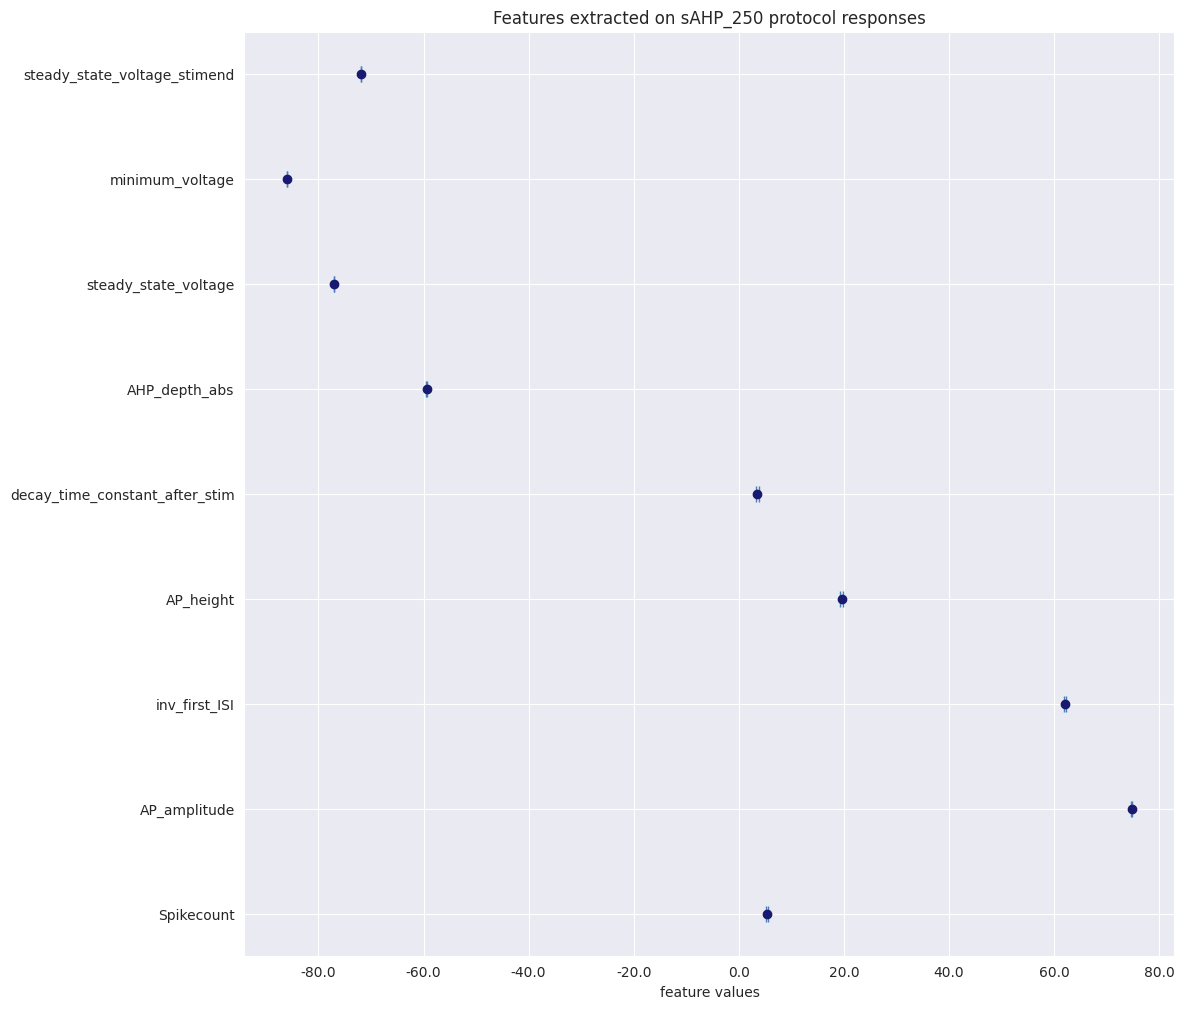

In [14]:
feature_plot(etype_sahp_df, sahp_250)

# Features extracted from the APThreshold_300 protocol

In [15]:
apthreshold_300 = "APThreshold_300"
apthreshold_df = features_df(etype_features, apthreshold_300)
apthreshold_df = drop_large_values_features(apthreshold_df)
apthreshold_df.head(10)

,feature,n,efel_settings,mean,variance,relative_variance
0,Spikecount,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",14.166667,0.687184,0.048507
1,AP_amplitude,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",72.549796,8.843906,0.121901
2,inv_time_to_first_spike,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",1.251683,0.053098,0.042421
3,ISI_log_slope,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-0.342702,0.016009,0.046715
4,ISI_CV,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",0.283915,0.015063,0.053056
5,AP1_amp,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",75.807292,8.253128,0.108870
6,APlast_amp,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",69.822395,9.849927,0.141071


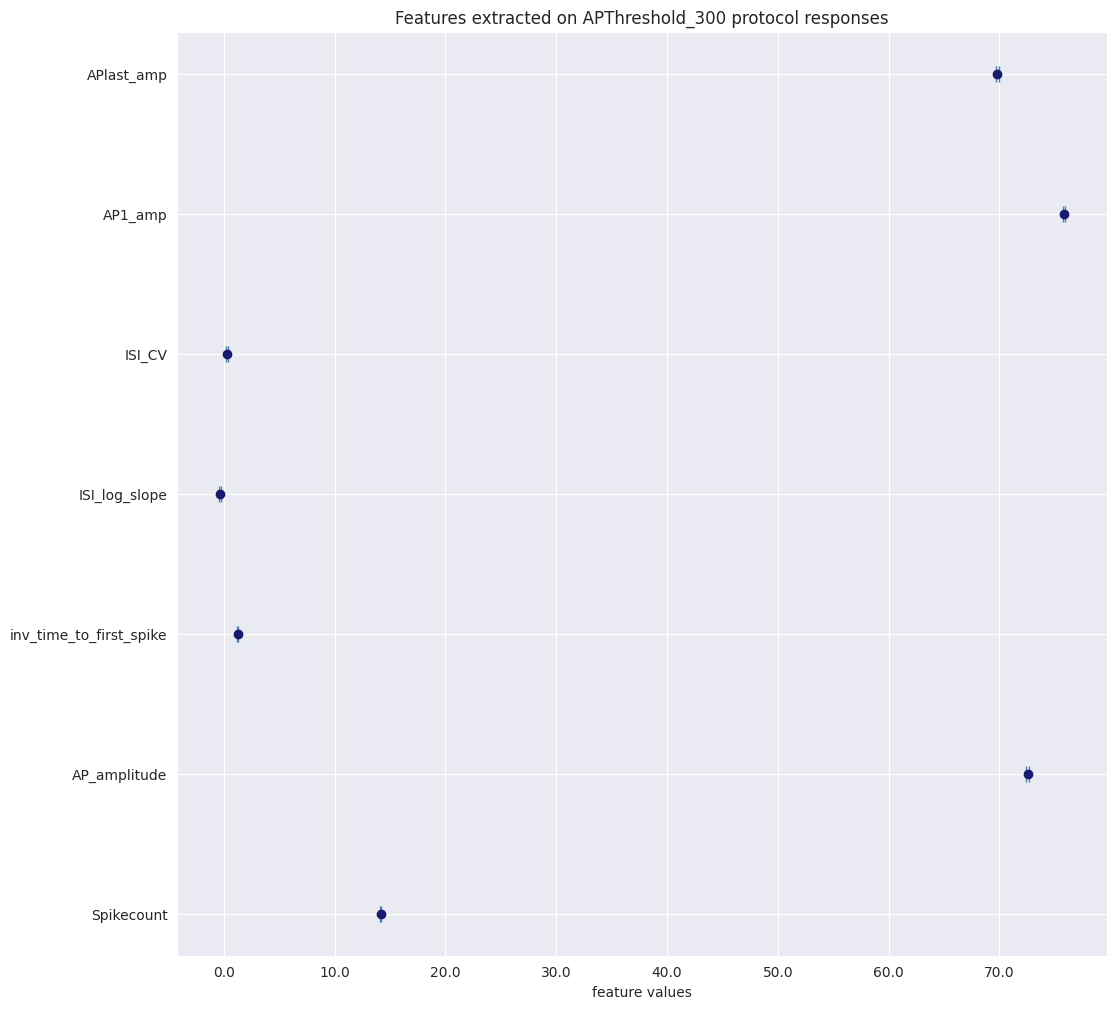

In [16]:
feature_plot(apthreshold_df, apthreshold_300)